<a href="https://colab.research.google.com/github/hane94/Machine-Learning-Practice/blob/master/lesson3_imdb(hyeseon)_lesson4%20%EC%BD%94%EB%A9%98%ED%8A%B8%20%EC%B6%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

텍스트 classifiation : 가짜뉴스 판별, 의학 보고서, 진단 등, 제품 관련 멘션들...하는데 활용

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [ ]:
df = pd.read_csv(path/'texts.csv') #read it with pandas
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [ ]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [ ]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [ ]:
data_lm.save() #save the databunch

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
data = load_data(path)

### Tokenization : take words and convert them into a standard form of tokens

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [ ]:
data = TextClasDataBunch.from_csv(path, 'texts.csv') #classification dataset
data.show_batch() #xx -> special token(separate units)

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [ ]:
data.vocab.itos[:10] #ten items of vocab -> possible token

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [ ]:
data.train_ds[0][0] #xxunk -> unknown token

Text xxbos xxmaj because ' cruel ' would be the only word in existence to describe the intentions of these film makers . xxmaj where do you even begin ? xxmaj in a spout of xxunk , i 'm going to start with the awful acting of nearly everybody in this movie . xxmaj xxunk that . xxmaj nearly does not belong in that sentence . i ca n't think of even one character who was portrayed well . xxmaj although , in all xxunk , it would be nearly impossible to portray these zero dimensional characters in a successful way . xxmaj still , the girl who played xxmaj xxunk ( whose name i xxunk do n't include - i 'm pretending she does n't exist ) remains one of the worst actors i 've ever seen , only xxunk by the guy who played xxmaj sebastian . xxmaj the story was xxmaj god awful . xxmaj it attempted to mirror the brilliance that was the first one but failed in so many ways . xxmaj pretty much every part of it was pointless - though i will admit ( xxunk ) that the plot twist was quite good it its surp

But the underlying data is all numbers

In [ ]:
data.train_ds[0][0].data[:10] #무비 리뷰를 리스트의 넘버들로 대체, 2일경우 xxbos 5일 경우 xxmaj를 의미 /vocab안에 토큰이 어디있는지

array([   2,    5,  107,   66, 3720,   66,   74,   43,    9,   83])

### With the data block API

We can use the data block API with NLP(자연어처리) and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
data = (TextList.from_csv(path, 'texts.csv', cols='text') #independent variables : text
                .split_from_df(col=2) #어떻게 나눌것인지
                .label_from_df(cols=0) #어떻게 레이블을 붙일것인지
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [ ]:
bs=48

Now let's grab the full dataset for what follows.

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas')]

In [ ]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1) 
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm() #lm = language model          
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [ ]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [ ]:
data_lm.show_batch()

idx,text
0,groups internationally have asked for comments about xxmaj jeffs from xxmaj the xxup lds church . xxmaj jeffs is not mentioned in the movie at all but i think that it is ironic that this movie with all it 's points about xxmaj joseph also point away from the fews of the xxup flds church and their leader at this time in the media world . xxmaj this is a
1,"climax , some of the jokes becomes lame . \n \n 3 . xxmaj storywise , this is xxmaj timon 's story and although the filmmakers try to integrate his tale with xxmaj simba 's , it makes the screenplay feel a little rushed at times . \n \n xxmaj but hey , those details does n't impact this otherwise amusing movie . xxmaj it is the only"
2,"one of my very favorites ... xxmaj christopher xxmaj lee , who plays xxmaj john xxmaj reid . xxmaj after moving into the home with his peculiar daughter xxmaj jane , the nanny that he hires becomes awfully suspicious as to the way xxmaj reid suppresses his daughter . xxmaj well come to find out ... if she knew what xxmaj lee did , she would have certainly understood ."
3,"xxmaj sousa adapted theme song for days afterwards guaranteed ! ) xxbos xxmaj at the point in time that xxmaj the xxmaj lady from xxmaj shanghai was being made , the marriage of xxmaj orson xxmaj welles and xxmaj rita xxmaj hayworth was disintegrating . xxmaj the film was as much an effort by xxmaj welles to rekindle the old flames as it was to make a classic noir ."
4,"she 's still a virgin . xxmaj really ? xxmaj yes , really . xxmaj pauline begins to draw closer to xxmaj adele and xxmaj adele finally confesses that she 'd like to rid herself of her hymen and she would like xxmaj pauline to do it for her . xxmaj pauline , now drawn sexually to xxmaj adele , performs the task with subdued relish . xxup now xxmaj"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) #CNN이 아니고 RNN을 생성

*여기 CNN보다 왜 RNN 쓰지 ?*

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


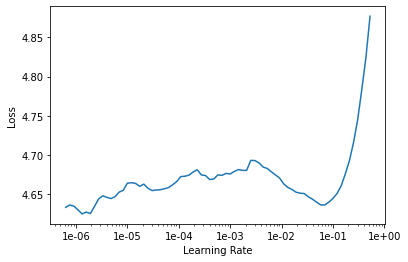

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.154908,4.028907,0.295460,26:05


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.873777,3.846457,0.313785,26:15
1,3.838392,3.805382,0.320648,26:14
2,3.807143,3.779789,0.324384,26:15
3,3.753798,3.747806,0.328038,26:14
4,3.704956,3.723449,0.330988,26:14
5,3.664742,3.700617,0.333525,26:20
6,3.625528,3.684546,0.335812,26:15
7,3.577188,3.674224,0.337210,26:14
8,3.547620,3.669702,0.337934,26:13
9,3.507543,3.669537,0.337938,26:14


In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES))) #예측

I liked this movie because it was good . It 's about Black Robe , that 's what it is . The characters are real , and they are well - conceived , original and believable . Also , it
I liked this movie because it was about a man who lives on the New York streets , and who happens to be a neo - Nazi . He has a lot of strange and mysterious things in him .


*예측 결과가 어떤지 해석 써 보시면 좋음*

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

여기까지 무비 리뷰 모델 형성(다음 단어를 예측하는) -> classifier단계를 통해 positive인지 negative인지 구별

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab) #랭귀지 모델과 정확히 일치하는 단어리스트를 사용해야함 *중요
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs)) #create databunch

data_clas.save('data_clas.pkl') #make a databunch

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [ ]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj my xxmaj comments for xxup vivah : - xxmaj its a charming , idealistic love story starring xxmaj shahid xxmaj kapoor and xxmaj amrita xxmaj rao . xxmaj the film takes us back to small pleasures like the bride and bridegroom 's families sleeping on the floor , playing games together , their friendly banter and mutual respect . xxmaj vivah is about the sanctity of marriage and",pos
"xxbos xxmaj by 1987 xxmaj hong xxmaj kong had given the world such films as xxmaj sammo xxmaj hung 's ` xxmaj encounters of the xxmaj spooky xxmaj kind ' xxmaj chow xxmaj yun xxmaj fat in xxmaj john xxmaj woo 's iconic ` a xxmaj better xxmaj tomorrow ' , ` xxmaj zu xxmaj warriors ' and the classic ` xxmaj mr xxmaj vampire ' . xxmaj jackie xxmaj",pos
"xxbos xxmaj waitress : xxmaj honey , here 's them eggs you ordered . xxmaj honey , like bee , get it ? xxmaj that 's called pointless foreshadowing . \n \n xxmaj edward xxmaj basket : xxmaj huh ? ( xxmaj on the road ) xxmaj basket : xxmaj here 's your doll back , little girl . xxmaj you really should n't be so careless with your",neg
"xxbos xxmaj beat a path to this important documentary that looks like an attractive feature . xxmaj forbidden xxmaj xxunk ) is simply a better ( cinematic ) version of xxmaj norma xxmaj khouri 's book xxmaj forbidden xxmaj love , and xxup that was a best - seller . xxmaj an onion - peeling of literary fraud and of a pretty woman , xxmaj xxunk is the very best",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5) #drop_mult - how much regularization
learn.load_encoder('fine_tuned_enc') #load pre-trained model

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj this movie makes a statement about xxmaj joseph xxmaj smith , what he stood for , and what the xxup lds church believes . xxmaj with all the current media coverage of a certain fugitive people have confused the xxup lds church with the xxup flds church and criminal fugitive xxmaj warren xxmaj jeffs . xxmaj jeffs is xxmaj not associated with the xxup lds church yet media groups internationally have asked for comments about xxmaj jeffs from xxmaj the xxup lds church . xxmaj jeffs is not mentioned in the movie at all but i think that it is ironic that this movie with all it 's points about xxmaj joseph also point away from the fews of the xxup flds church and their leader at this time in the media world . xxmaj this is a movie about xxmaj joseph xxmaj smith and a great one at that . xxmaj some of the most obvious differences between xxmaj jeffs and xxmaj joseph is portrayed in xxmaj joseph 's humani

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


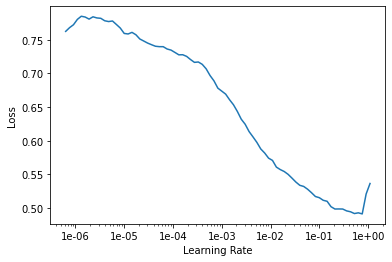

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.332983,0.261171,0.894280,05:50


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2) #unfreeze last 2 layers (don't unfreeze the whole thing)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7)) #training a little bit more

epoch,train_loss,valid_loss,accuracy,time
0,0.289871,0.218540,0.912920,05:37


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3) #unfreeze the next layer
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7)) #training a little bit more

epoch,train_loss,valid_loss,accuracy,time
0,0.235444,0.186799,0.929080,05:18


In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze() #unfreeze the whole thing
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) #training a little bit more 

epoch,train_loss,valid_loss,accuracy,time
0,0.208531,0.176927,0.931600,05:56
1,0.201276,0.179333,0.930440,05:19


moms = Momentum's

In [ ]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([1.9508e-06, 1.0000e+00]))

*결과 해석 써 보시면 좋음*